## Day 30 Lecture 1 Assignment

In this assignment, we will build our first random forest model. We will use a dataset containing churn information for a telephone company's customers.

In [1]:
%matplotlib inline
%load_ext nb_black

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

#!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

<IPython.core.display.Javascript object>

Read in the telecom churn dataset.

In [2]:
data_url = "https://docs.google.com/spreadsheets/d/1WmHb_gnUP523asHiAGIMAhqNQ0zpi3eiVBWbwkx6aQ0/export?format=csv"
churn_raw = pd.read_csv(data_url)
churn_raw.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


<IPython.core.display.Javascript object>

In [4]:
churn_map = {"Yes": 1, "No": 0}
churn_raw[["Churn"]] = churn_raw[["Churn"]].replace(churn_map)
churn_raw["Churn"] = pd.to_numeric(churn_raw["Churn"])
churn_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
CustomerID                   51047 non-null int64
Churn                        51047 non-null int64
MonthlyRevenue               50891 non-null float64
MonthlyMinutes               50891 non-null float64
TotalRecurringCharge         50891 non-null float64
DirectorAssistedCalls        50891 non-null float64
OverageMinutes               50891 non-null float64
RoamingCalls                 50891 non-null float64
PercChangeMinutes            50680 non-null float64
PercChangeRevenues           50680 non-null float64
DroppedCalls                 51047 non-null float64
BlockedCalls                 51047 non-null float64
UnansweredCalls              51047 non-null float64
CustomerCareCalls            51047 non-null float64
ThreewayCalls                51047 non-null float64
ReceivedCalls                51047 non-null float64
OutboundCalls                51047 non-null float64
InboundCall

<IPython.core.display.Javascript object>

In [5]:
churn_raw.corr().abs()

corred = churn_raw.corr().abs()
s = corred.unstack()
s = s.reset_index()

s = s[s["level_0"] == "Churn"].sort_values(by=0, ascending=False)
s.head(17)

,level_0,level_1,0
37,Churn,Churn,1.000000
64,Churn,CurrentEquipmentDays,0.103688
67,Churn,RetentionCalls,0.065301
40,Churn,TotalRecurringCharge,0.061296
39,Churn,MonthlyMinutes,0.050166
36,Churn,CustomerID,0.041558
55,Churn,OffPeakCallsInOut,0.040784
63,Churn,HandsetModels,0.040048
54,Churn,PeakCallsInOut,0.040029
51,Churn,ReceivedCalls,0.037453


<IPython.core.display.Javascript object>

In [8]:
churn_df = churn_raw[
    [
        "Churn",
        "CurrentEquipmentDays",
        "RetentionCalls",
        "TotalRecurringCharge",
        "MonthlyMinutes",
        "OffPeakCallsInOut",
        "HandsetModels",
        "PeakCallsInOut",
        "ReceivedCalls",
        "CustomerCareCalls",
        "RetentionOffersAccepted",
        "UniqueSubs",
        "InboundCalls",
        "PercChangeMinutes",
        "Handsets",
        "OutboundCalls",
        "OwnsMotorcycle",
    ]
]
churn_df = churn_df.dropna()

<IPython.core.display.Javascript object>

In [9]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50679 entries, 0 to 51043
Data columns (total 17 columns):
Churn                      50679 non-null int64
CurrentEquipmentDays       50679 non-null float64
RetentionCalls             50679 non-null int64
TotalRecurringCharge       50679 non-null float64
MonthlyMinutes             50679 non-null float64
OffPeakCallsInOut          50679 non-null float64
HandsetModels              50679 non-null float64
PeakCallsInOut             50679 non-null float64
ReceivedCalls              50679 non-null float64
CustomerCareCalls          50679 non-null float64
RetentionOffersAccepted    50679 non-null int64
UniqueSubs                 50679 non-null int64
InboundCalls               50679 non-null float64
PercChangeMinutes          50679 non-null float64
Handsets                   50679 non-null float64
OutboundCalls              50679 non-null float64
OwnsMotorcycle             50679 non-null object
dtypes: float64(12), int64(4), object(1)
memory us

<IPython.core.display.Javascript object>

Perform the following preprocessing steps:

- This dataset has many columns; identify a subset of 10-15 features that you think could affect a customer's propensity to churn (also called "customer loss" or "customer attrition"). Include at least 1 categorical variable.
- Drop all rows that containing any missing values (this should be a fairly small number of rows)
- Convert the response from a string to a binary 1-0 encoding.

In [10]:
# answer goes here
X = churn_df.drop(columns=["Churn"])
y = churn_df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [11]:
encoder = LeaveOneOutEncoder(cols=["OwnsMotorcycle"])

encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

<IPython.core.display.Javascript object>

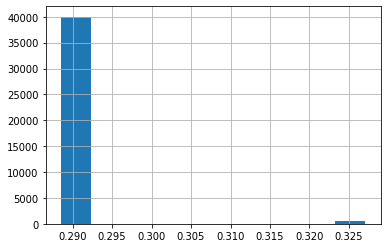

<IPython.core.display.Javascript object>

In [14]:
X_train["OwnsMotorcycle"].hist()
plt.show()

Although some implementations of tree-based models support categorical variables directly, scikit-learn's implementation does not, so we will need to convert our categorical variable(s) into numbers. In linear regression, we used one-hot/dummy encoding, but this has drawbacks that can be particularly problematic in the context of trees. Namely, dummy encoding can lead to very sparse columns when dealing with high-dimensional categorical features; the tree treats these levels as indepedent features is very unlikely to make a split on any of the individual levels, since the corresponding columns consist almost entirely consist of a single value.

Ideally, we would consider all of the levels simultaneously, which trees can do efficiently. However, sklearn does not implement this efficient algorithm for splitting on categorical variables. In this situation, a better alternative to dummy encoding is leave-one-out-encoding. This transforms each categorical into its conditional probability of the positive class, excluding the observation itself to avoid potential data leakage. Perform the following steps:

- Create an 80-20 train/test split on the data
- Fit a leave-one-out encoder to the training data and encode the categorical variables in the training data. The category_encoders package is helpful for this task. (Note that this ordering is important; if we fitted the encoder to the full dataset before making the train/test split, we would introduce data leakage by allowing the test data to affecting the estimates of the category-conditional probabilities.)

In [ ]:
# answer goes here





Next, fit the random forest model. You can tinker with or tune the parameters if you like, although we will use the default parameter values.

In [15]:
# answer goes here

model = RandomForestClassifier()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score: 0.9765680882026491
test_score: 0.7067876874506709


<IPython.core.display.Javascript object>

To evaluate our model, produce the predicted values for the test sample. Remember to apply our previously fitted encoder to the test data prior to making predictions.

In [17]:
# answer goes here
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)


array([[6771,  580],
       [2392,  393]])

<IPython.core.display.Javascript object>

After making the predictions, print out the classification report (sklearn.metrics.classification_report). In addition, plot the confusion matrix and ROC curve. How did our model perform?

In [18]:
# answer goes here
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      7351
           1       0.40      0.14      0.21      2785

    accuracy                           0.71     10136
   macro avg       0.57      0.53      0.51     10136
weighted avg       0.65      0.71      0.65     10136



<IPython.core.display.Javascript object>

Print the feature importances, ordered by importance from high to low. What is the default sklearn feature importance metric?

In [20]:
# answer goes here
importance_df = pd.DataFrame(
    {"feat": X_train.columns, "importance": model.feature_importances_}
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
0,CurrentEquipmentDays,0.139520
12,PercChangeMinutes,0.120841
3,MonthlyMinutes,0.119659
6,PeakCallsInOut,0.095335
7,ReceivedCalls,0.093484
4,OffPeakCallsInOut,0.092954
14,OutboundCalls,0.084023
2,TotalRecurringCharge,0.069728
11,InboundCalls,0.061520
8,CustomerCareCalls,0.043392


<IPython.core.display.Javascript object>